In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib
matplotlib.rc('font', family='arial') 
import matplotlib.pyplot as plt
import numpy as np
from h5py import File
from fish.image.zds import ZDS
from fish.image.vol import InterpArray
from os.path import exists
import dask.array as da
from dask.distributed import Client
from scipy.ndimage.filters import median_filter

from fish.util.distributed import get_downsampled_baseline
from os import remove

import flika as flk
flk.start_flika()
from flika.window import Window as flw

def axs_format(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
def get_klab_dataset(path):
    from glob import glob
    from fish.util.fileio import to_dask
    files = sorted(glob(path + 'TM*/*/*CM0*'))
    dsk = to_dask(files).squeeze().transpose(0,3,2,1)
    
    return dsk

Starting flika
Starting flika inside IPython


In [255]:
which_dataset = 'keller'

In [256]:
if which_dataset == 'ahrens':
    base_dir = '/nrs/ahrens/Yu/SPIM/active_dataset/GliaNeuron/20170221/fish4/20170221_4_3_gfaprgeco_hucgc_6dpf_wholebrain_faster_brighter_20170221_174442_noephys/'
    dset = ZDS(base_dir + 'raw/')
    data = dset.data
    exp_name = base_dir.split('/')[-2]
    reg_dir = f'/groups/ahrens/ahrenslab/davis/tmp/{exp_name}/'
    reg_path = reg_dir + 'regparams_affine.npy'
        
    fs_im = dset.metadata['volume_rate']
    shifts = -np.load(reg_path)[:,:-1,-1]

    window_seconds = 300
    window_frames = int(window_seconds * fs_im)
    camera_baseline = 80
    percentile = 20
    
    fig, axs = plt.subplots(figsize=(12,4))
    axs.plot(shifts)
    shifts_filt = median_filter(shifts, size=(300,1))
    axs.plot(shifts_filt)

elif which_dataset == 'keller':
    data = get_klab_dataset('/nrs/keller/ForDavis/Dme_L1_57C10GCaMP641-54B03TDT_0_20130912_145536.corrected/SPM00/').transpose(0,1,3,2)
    data = data[750:]
    
    # 8 ms exposure * 40 planes
    fs_im = (.08 * data.shape[1])
    
    window_seconds = 90
    window_frames = int(window_seconds * fs_im)
    camera_baseline = 80
    percentile = 20
    
    reg_dir = '/groups/ahrens/ahrenslab/davis/tmp/Dme_L1_57C10GCaMP641-54B03TDT_0/'
    if not exists(reg_dir):
        from os import makedirs
        makedirs(reg_dir)

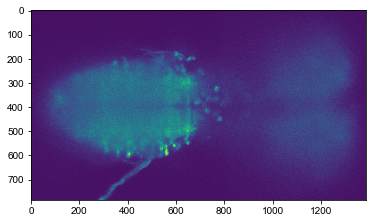

In [257]:
rois = dict()
rois['glia'] = slice(0,None), slice(16,17), slice(None,1024), slice(20,None)
rois['neurons'] = slice(0,None), slice(16,17), slice(1024, None), slice(20,None)
rois['explant'] = slice(0,None), slice(20,21), slice(None), slice(None)

cell_group = 'explant'

roi = rois[cell_group]
crop=slice(None), slice(None), slice(10,-10), slice(10,-10)
sample = data[roi][-1].compute(scheduler='threads').squeeze()
plt.imshow(sample)

In [258]:
def mybl(v):
    from fish.image.vol import baseline
    window = window_frames
    downsample = 1;
    return baseline(v, window, percentile, downsample, axis=0).astype('float32')

def mydff(v):
    return (v / mybl(v).clip(1,None))

def shift_yx(im, shifts, block_id):
    from scipy.ndimage.interpolation import shift
    t = block_id[0] 
    im_ = im
    if im.dtype == 'float16':
        im_ = im.astype('float32')
    return shift(im_, (0,0, *shifts[t]), order=1, cval=100).astype(im.dtype)


In [6]:
from fish.util.distributed import get_jobqueue_cluster
cluster = get_jobqueue_cluster()
client = Client(cluster)
client

Client Scheduler: tcp://10.36.111.13:43955 Dashboard: http://10.36.111.13:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [259]:
if which_dataset == 'ahrens':
    data_tx = data[roi].astype('float32').map_blocks(shift_yx, shifts, dtype='float32')
    data_filt = data_tx.map_blocks(lambda v: median_filter(v, size=(1,1,3,3)), dtype='float32')
   
    rechunked = data_tx.rechunk((-1, 'auto', 'auto','auto'))
    ds_factors = [12, 24, 36, 48]
    
elif which_dataset == 'keller':
    ds_factors = [12, 24, 36, 48]
    data_filt = data[roi].astype('float32')
    rechunked = data_filt.rechunk((-1, 'auto', 'auto','auto'))

In [268]:
steps / fs_im

array([29.375, 14.062,  9.375,  6.875])

In [267]:
steps = np.array([((data.shape[0]//k) + data.shape[0]) // k for k in ds_factors])
window = window_frames

bl_fnames = [reg_dir + f'baseline_ds{ds}.h5' for ds in ds_factors]

compute_baselines = False
if compute_baselines:
    
    params = [get_downsampled_baseline(data_filt, factor=ds, window=window, perc=percentile) for ds in ds_factors]
    cluster.start_workers(400)
    
    for ind, p in enumerate(params):
        fn = bl_fnames[ind]
        with File(fn, mode='a') as fh:
            try:
                fh['keyframes'] = p[0]
            except:
                fh['keyframes'][()] = p[0]
            dsb_ = np.array([tp.compute() for tp in p[1]])
            try:
                fh['baseline'][(slice(None), *roi[1:])] = dsb_
            except:
                fh.create_dataset('baseline', (len(p[0]), *data.shape[1:]))
                fh['baseline'][(slice(None), *roi[1:])] = dsb_

cluster.stop_all_jobs()

In [ ]:
# make some baselines 

In [261]:
# get the global mean of the whole experiment
cluster.start_workers(50)
mean_ts = data_filt.mean((1,2,3)).compute()
cluster.stop_all_jobs()

In [262]:
mean_bl = mybl(mean_ts)
ds_subsamples = np.unique(np.geomspace(5, 100, 20).astype('int'))
kfs = [np.linspace(0, mean_bl.shape[0]-1, d).astype('int') for d in ds_subsamples]
intervals = np.array([np.gradient(k).mean().astype('int') for k in kfs])
lerped_bl = np.zeros([len(kfs), mean_bl.shape[0]])
for ind, kf in enumerate(kfs):
    lerped_bl[ind] = InterpArray(kf, mean_bl[kf], mean_bl.shape, 0)[:]

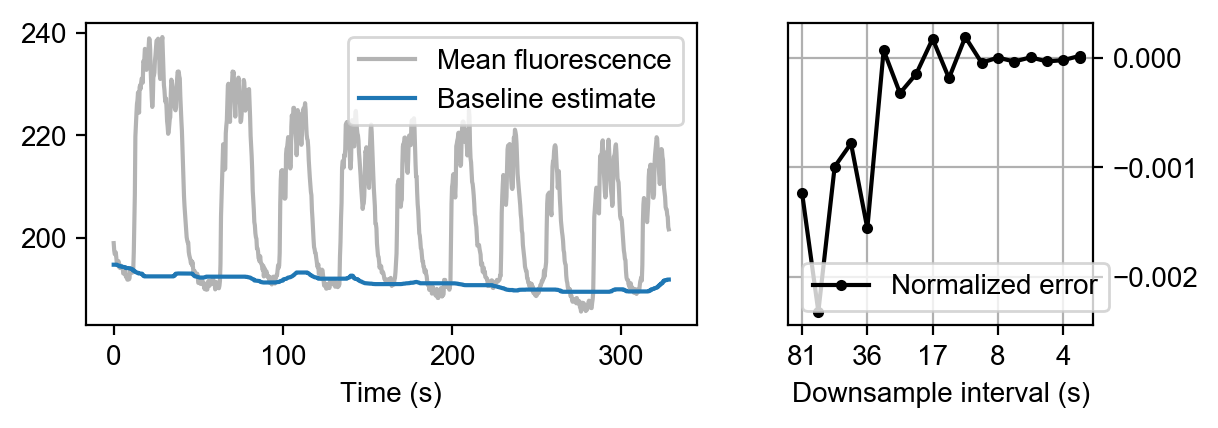

In [272]:
mse = ((mean_bl - lerped_bl)**2).mean(1)
pcte = ((mean_bl - lerped_bl) / mean_bl).mean(1)
x_im = np.arange(mean_ts.shape[0]) / fs_im
fig, axs = plt.subplots(figsize=(6.5, 2), dpi=200, ncols=2, gridspec_kw={'width_ratios':(2,1)})

axs[0].plot(x_im, mean_ts, color=(.7,.7,.7), label='Mean fluorescence')
axs[0].plot(x_im, mean_bl, label='Baseline estimate')
axs[0].legend()
axs[0].set_xlabel('Time (s)')
axs[1].plot((intervals/fs_im).astype('int').astype('str'), pcte,'.-',color='k', label='Normalized error')
axs[1].grid(True)
axs[1].set_xticks(axs[1].get_xticks()[::4])
axs[1].yaxis.tick_right()
axs[1].set_xlabel('Downsample interval (s)');
axs[1].legend()

fname = f'baseline_mean_{cell_group}.pdf'
plt.savefig(f'../../figures/ch5/{fname}')

In [9]:
cluster.start_workers(100)
errs = [] 
blfull_ = (rechunked[crop] - camera_baseline).map_blocks(mybl, dtype='float32').squeeze().compute()

tcrop = slice(window_frames//2, -window_frames//2)
tcrop  

for bl_fname in bl_fnames:
    bl_h5 = da.from_array(File(bl_fname, libver='latest', mode='r')['baseline'], chunks=data.chunksize).astype('float32')
    kf = File(bl_fname, mode='r')['keyframes'][:]
    dsb = InterpArray(kf, bl_h5, full_shape=data.shape, interpolation_axis=0)[roi].astype('float32')        
    
    blds_ = (dsb[crop] - camera_baseline).squeeze().compute()
    err = ((blds_[tcrop] / blfull_[tcrop]) - 1)
    
    result = err.mean(0), err.max(0)
    errs.append(result)
    del dsb
    
cluster.stop_all_jobs()
errs = np.array(errs)

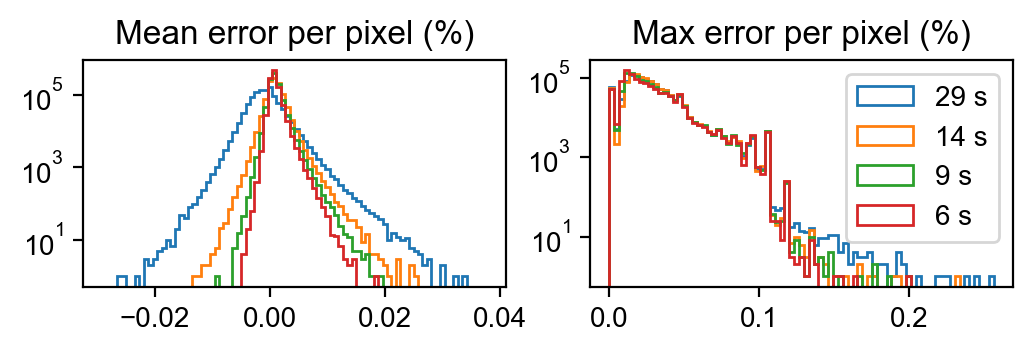

In [10]:
nbins = 80
bins_mean = np.linspace(errs[:,0].ravel().min(), errs[:,0].ravel().max(), nbins)
bins_max = np.linspace(np.abs(errs[:,1]).ravel().min(), np.abs(errs[:,1]).ravel().max(), nbins)

fig, axs = plt.subplots(ncols=2, figsize=(6,1.5), dpi=200)

[axs[0].hist(err[0].ravel(), bins=bins_mean, histtype='step') for err in errs];
[axs[1].hist(np.abs(err[1]).ravel(), bins=bins_max, histtype='step', label=f'{int(steps[ind]/fs_im)} s') for ind, err in enumerate(errs)];
axs[0].set_xlim(np.abs(axs[0].get_xlim()) * np.array([-1.1,1.1]))
axs[0].title.set_text('Mean error per pixel (%)')
axs[1].title.set_text('Max error per pixel (%)')

axs[1].legend()
[ax.semilogy() for ax in axs]
fname = f'baseline_error_{cell_group}_plots.pdf'
plt.savefig(f'../../figures/ch5/{fname}')

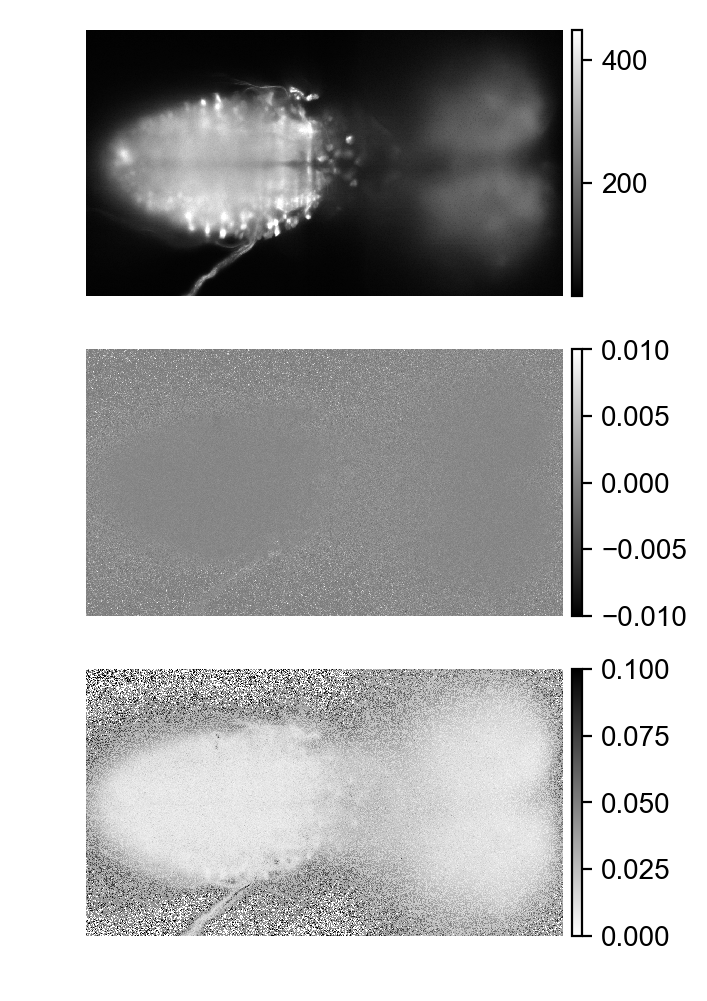

In [13]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axs = plt.subplots(figsize=(4,6),nrows=3, dpi=200)
axs[0].imshow(blfull_[0], cmap='gray', clim=(15,450))
axs[1].imshow(errs[-1,0], cmap='gray', clim=(-.01, .01))
axs[2].imshow(errs[-1,1], cmap='gray_r', clim=(0,.1))

for ax in axs:
    ax.axis('off')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.05)
    plt.colorbar(ax.images[0], cax=cax)
    
fname = f'baseline_error_{cell_group}_images.pdf'
plt.savefig(f'../../figures/ch5/{fname}')